In [51]:
import geopandas as gpd
import xarray as xr
import rioxarray as rioxr
import rasterio
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib_scalebar.scalebar import ScaleBar
import os

# Create root directory path
root = os.path.join('/', 
             'Users', 
             'jpcohen', 
             'EDS-220', 
             'eds220-hwk4')

# Create path to landsat imagery
landsat_fp = os.path.join(root, 
                         'data', 
                         'landsat8-2018-01-26-sb-simplified.nc')

# Create path to thomas fire shapefile
thomas_fp = os.path.join(root,
                        'data',
                        'thomas_perim',
                        'thomas_perim.shp')

# Open landsat dataArray
landsat = rioxr.open_rasterio(landsat_fp)

## Preliminary Data Exploration

In [53]:
landsat

<xarray.Dataset> Size: 25MB
Dimensions:      (band: 1, x: 870, y: 731)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0
Data variables:
    red          (band, y, x) float64 5MB ...
    green        (band, y, x) float64 5MB ...
    blue         (band, y, x) float64 5MB ...
    nir08        (band, y, x) float64 5MB ...
    swir22       (band, y, x) float64 5MB ...

In [47]:
print('Landsat Dimensions: \n', landsat.dims, '\n')
print('Landsat Coordinates: \n', landsat.coords, '\n')
print('Landsat CRS: \n', landsat.rio.crs, '\n')

Landsat Dimensions: 
 FrozenMappingWarningOnValuesAccess({'band': 1, 'x': 870, 'y': 731}) 

Landsat Coordinates: 
 Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 7kB 1.213e+05 1.216e+05 ... 3.557e+05 3.559e+05
  * y            (y) float64 6kB 3.952e+06 3.952e+06 ... 3.756e+06 3.755e+06
    spatial_ref  int64 8B 0 

Landsat CRS: 
 EPSG:32611 



# Preliminary Summary of the Landsat Data

The data has 3 dimensions. The first, is called 'band', and it refers to the number of bands in a `DataArray`. In this case it is only length 1, because the data only contains 1 band.

The other two dimensions are x and y, refering to longtitude and latitude. They have a length of 870 and 731 respectively, a unit of a meter, and a CRS of EPSG:32611.

Furthermore, the data has 5 variables: red, green, blue, nir08, and swir22, referring to red, green, blue, near infrared, and short wave infrared respectively. The respective wavelength ranges for each band (in nm) are 640-670, 530-590, 450-510, 850-880, and 2110-2290. 

The data otherwise has no attributes, but 3 indexes, one associated with each dimension.

In [3]:
# Drop `band` dimension
landsat_bandless = (landsat
                    .squeeze()
                    .drop_vars('band'))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


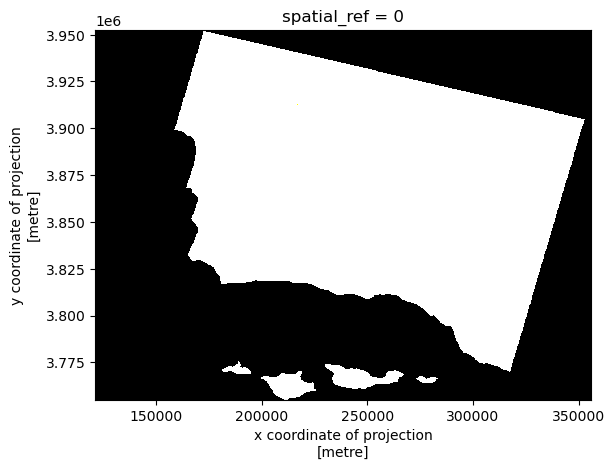

In [4]:
# Plot landsat bands without adjusting for cloud cover
landsat_bandless[['red', 'green', 'blue']].to_array().plot.imshow()

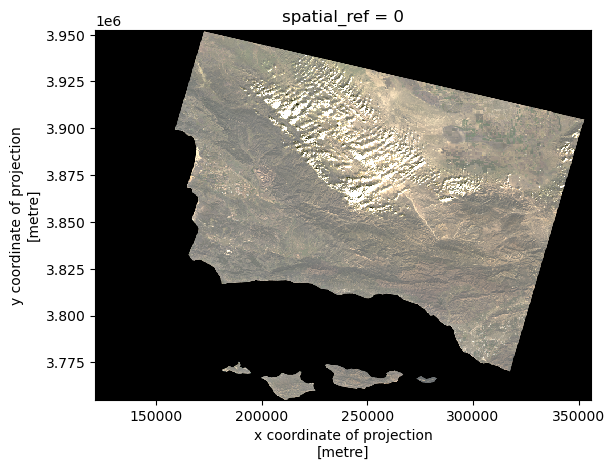

In [5]:
# Create false color dataArray
true_col = landsat_bandless[['red', 'green', 'blue']]

# Plot landsat bands adjusting for cloud cover
true_col.to_array().plot.imshow(robust = True)

# Plotting an `DataArray` with `robust` = True vs False

Factors like cloud cover can cause a `DataArray`/`raster` to have values extreme enough to drag a color scale away from the RGB range. When the `robust` argument equals true, `.plot.imshow` cuts off the extreme values from the 2nd and 98th percentile onward and just visualizes everything in between.

The top visualization demonstrates what happens when `robust` equals false. The clouds reflect so much light in comparison to the visual light spectrum that red, blue, and green light are outliers in comparison. cutting off these extreme values allows the function to focus on just the visible light spectrum.

# Create false color image

The color mapping as as follows:
- Red = Shortwave-IR
- Green = NIR
- Blue = Red

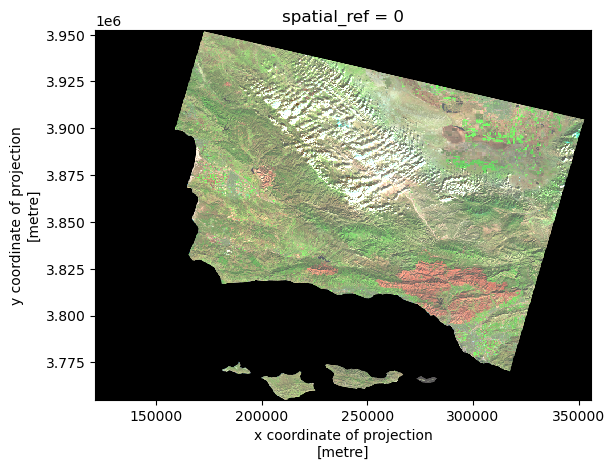

In [6]:
# Create false color dataArray
false_col = landsat_bandless[['swir22', 'nir08', 'red']]

# Plot landsat bands adjusting for cloud cover
false_col.to_array().plot.imshow(robust = True)

# False Color **with** 2017 Thomas Fire Perimeter

In [7]:
# Import thomas fire shapefile
thomas = gpd.read_file(thomas_fp)

# Match crs
thomas = thomas.to_crs(false_col.rio.crs)

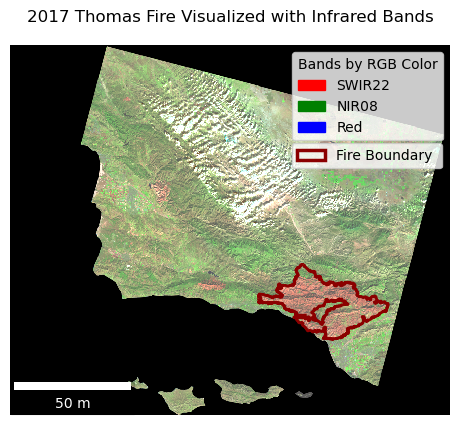

In [38]:
# Init matplotlib
fig, ax = plt.subplots()
ax.axis('off')

# Plot false color landsat dataArray
false_col.to_array().plot.imshow(ax = ax,
                                 robust = True)

# Plot thomas fire perimeter
thomas.boundary.plot(ax = ax,
                     color = 'darkred',
                     linewidth = 2,
                             label = 'test2')

# Init legend for landsat bands
legend_labels1 = [Patch(color = 'red', label = 'SWIR22'), 
                 Patch(color = 'green', label = 'NIR08'), 
                 Patch(color = 'blue', label = 'Red')]

# Init legend for thomas boundary
legend_labels2 = [Patch(color = 'darkred', 
                       label = 'Fire Boundary ',
                       linewidth = 2.5,
                       fill = False)]

# Declare legend variable for landsat bands
legend1 = ax.legend(handles = legend_labels1, 
                    loc = 'upper right', 
                    title = 'Bands by RGB Color',
                    alignment = 'left')

# Vizualize landsat legend and allow a second legend
ax.add_artist(legend1)

# Declare legend for thomas boundary
legend2 = ax.legend(handles = legend_labels2, 
                    loc = [0.64,0.667], 
                    borderaxespad = 1)

# Create scalebar
ax.add_artist(ScaleBar(0.08, 
                       "cm", 
                       length_fraction=0.30, 
                       width_fraction = 0.02,
                       location = 'lower left',
                       box_alpha = 0.2,
                       box_color = 'k',
                       color = 'w'))

# Establish title
ax.set_title('2017 Thomas Fire Visualized with Infrared Bands')

plt.show()

### Description

This RGB map highlights the area burned by the 2017 Thomas Fire. Shortwave infrared is uniqely bright in newly burned areas, which may because water and other moist areas absorb this wavelength range while dry areas reflect it. Near infrared has a similar behavior in regards to moisture, but has particularly strong reflectance off of plants, particularly healthy ones, showing off the forested areas of the map. Simultaneously, the red band is great at showing where plants are not, as they absorb red light.

In other words, when the shortwave infrared band is mapped to red, the burned areas of the Thomas Fire will glow red. Conversely, placing near infrared on green and the red band on blue shows otherwise the vegetation of the rest of the landscape, largely unrelated to the fire.